In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

Basic information about data:

In [2]:
df = pd.read_csv('University_Admission.csv')
df.shape

(1534, 108)

In [5]:
set(df.dtypes)

{dtype('float64'), dtype('O')}

How many rows have missing values?

In [6]:
df['missing'] = df.isnull().sum(axis = 1)
len(df['missing'] > 0)

1534

Columns of which data types are missing?

In [7]:
len(df.columns[ df.isnull().sum() > 0 ])
categorical_var = df.select_dtypes(include='O')
len(categorical_var.columns[ categorical_var.isnull().sum() > 0 ])
#no categorical variable is null, meaning ALL the float variables have missing values

0

It seems like all of rows have missing values. Also, it seems like only the float64 columns have missing values. All the categorical variables have no NaN's.


After further analysis which I have not shown here I decided to get rid of the rows with atleast 50% missing.
The 50% cutoff was arbitrary.

In [8]:
df = df.iloc[list(df['missing'] < df.shape[1]*0.5)]

In [9]:
df = df.drop(columns=['missing'])

Now I am looking at columns. After getting rid of bad rows, I decided to check out the columns.

In [10]:
len(df.columns[ df.isnull().sum() > 0 ])

76

In [11]:
len(df.columns[ df.isnull().sum() > 0.75*df.shape[0]])

0

Because these are all numeric values and there are no columns with missing values more than 75% I do not feel comfortable removing any of the columns altogether. 


However, many of the NaN's could very well be 0. 

For any columns starting with "percent," "Number," I will just subsitute all NaN's with 0's. However, to be on the safe side, I will also convert all the columns with NaN to dummy variables. For the rest I will use the fill mean function.

Seeing that 61 columns have NaN's. This will add another 61 dummy columns (1 or 0: NaN or not).

In [12]:
#get all the columns with atleast 1 missing value and remove them from the big one
all_missing = df[ df.columns[ df.isnull().sum() > 0 ] ]
df = df.drop(columns = all_missing.columns)
list(all_missing.columns)

['Applicants total',
 'Admissions total',
 'Enrolled total',
 'Percent of freshmen submitting SAT scores',
 'Percent of freshmen submitting ACT scores',
 'SAT Critical Reading 25th percentile score',
 'SAT Critical Reading 75th percentile score',
 'SAT Math 25th percentile score',
 'SAT Math 75th percentile score',
 'SAT Writing 25th percentile score',
 'SAT Writing 75th percentile score',
 'ACT Composite 25th percentile score',
 'ACT Composite 75th percentile score',
 'Estimated enrollment, full time',
 'Estimated enrollment, part time',
 'Estimated undergraduate enrollment, full time',
 'Estimated undergraduate enrollment, part time',
 'Estimated freshman undergraduate enrollment, total',
 'Estimated freshman enrollment, full time',
 'Estimated freshman enrollment, part time',
 'Estimated graduate enrollment, total',
 'Estimated graduate enrollment, full time',
 'Estimated graduate enrollment, part time',
 'Percent admitted - total',
 'Admissions yield - total',
 'Tuition and fees, 2

In [13]:
dummy = pd.get_dummies(all_missing, columns=all_missing.columns, dummy_na=True)
na_columns = dummy[[c for c in dummy if c.endswith('nan')]]
na_columns.shape

(1523, 76)

In [14]:
zero_fill = all_missing[[c for c in all_missing if (c.startswith('Number') 
                                                 or c.startswith('Percent') ) 
                                            and not c.endswith('scores')]]
all_missing = all_missing.drop(columns = zero_fill.columns)
all_missing.shape

(1523, 35)

In [15]:
fill_mean = lambda col: col.fillna(col.mean()) # Mean function
mean_fill = all_missing.apply(fill_mean, axis=0) #Fill all missing values with the mean of the column.
mean_fill.shape

(1523, 35)

Before we concatenate all the changes we made to the numeric columns let's all change the categorical columns. I did not include the name of the college because that is unique and I did not include the state because that would create 50 different dummy variables and would not help anyone.

In [16]:
categorical_var = df.select_dtypes(include='O').drop(columns = ['Name', 'State abbreviation', 'FIPS state code'])
df = df.drop(columns = categorical_var.columns)

In [17]:
categorical_dummies = pd.get_dummies(categorical_var, columns=categorical_var.columns)
categorical_dummies.shape

(1523, 38)

In [18]:
df = pd.concat([df, zero_fill, mean_fill, na_columns, categorical_dummies], axis=1)
df

,Name,"Estimated enrollment, total","Estimated undergraduate enrollment, total",Number of students receiving an Associate's degree,State abbreviation,FIPS state code,Total enrollment,Full-time enrollment,Part-time enrollment,Undergraduate enrollment,...,Degree of urbanization (Urban-centric locale)_Town: Remote,Carnegie Classification 2010: Basic_Baccalaureate Colleges--Arts & Sciences,Carnegie Classification 2010: Basic_Baccalaureate Colleges--Diverse Fields,Carnegie Classification 2010: Basic_Baccalaureate/Associate's Colleges,Carnegie Classification 2010: Basic_Doctoral/Research Universities,Carnegie Classification 2010: Basic_Master's Colleges and Universities (larger programs),Carnegie Classification 2010: Basic_Master's Colleges and Universities (medium programs),Carnegie Classification 2010: Basic_Master's Colleges and Universities (smaller programs),Carnegie Classification 2010: Basic_Research Universities (high research activity),Carnegie Classification 2010: Basic_Research Universities (very high research activity)
0,Alabama A & M University,5024.0,4055.0,0.0,Alabama,Alabama,5020.0,4439.0,581.0,4051.0,...,0,0,0,0,0,1,0,0,0,0
1,University of Alabama at Birmingham,18568.0,11502.0,0.0,Alabama,Alabama,18568.0,11961.0,6607.0,11502.0,...,0,0,0,0,0,0,0,0,0,1
2,Amridge University,626.0,313.0,5.0,Alabama,Alabama,631.0,323.0,308.0,322.0,...,0,1,0,0,0,0,0,0,0,0
3,University of Alabama in Huntsville,7376.0,5696.0,0.0,Alabama,Alabama,7376.0,4802.0,2574.0,5696.0,...,0,0,0,0,0,0,0,0,0,1
4,Alabama State University,6076.0,5357.0,0.0,Alabama,Alabama,6075.0,5182.0,893.0,5356.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,University of South Florida-Sarasota-Manatee,1889.0,1739.0,0.0,Florida,Florida,1877.0,875.0,1002.0,1728.0,...,0,0,0,0,0,0,1,0,0,0
1530,The Kingâ€™s College,504.0,504.0,0.0,New York,New York,516.0,493.0,23.0,516.0,...,0,1,0,0,0,0,0,0,0,0
1531,Ottawa University-Online,445.0,379.0,0.0,Kansas,Kansas,458.0,1.0,457.0,383.0,...,0,0,1,0,0,0,0,0,0,0
1532,Providence Christian College,68.0,68.0,0.0,California,California,66.0,66.0,0.0,66.0,...,0,1,0,0,0,0,0,0,0,0


Question 1: Which colleges have an abnormal amount of women and minorities?

In [19]:
df[['Name', 'Percent of total enrollment that are women']
  ][df['Percent of total enrollment that are women']%100 == 0
   ].sort_values(by=['Percent of total enrollment that are women'], ascending=False)

,Name,Percent of total enrollment that are women
264,Spelman College,100.0
374,Saint Mary's College,100.0
641,College of Saint Benedict,100.0
786,Barnard College,100.0
904,Bennett College,100.0
256,Morehouse College,0.0
378,Wabash College,0.0
1367,Hampden-Sydney College,0.0


In [20]:
df[['Name', 'Percent of total enrollment that are women']
  ][df['Percent of total enrollment that are women']%100 > 0
   ].sort_values(by=['Percent of total enrollment that are women'], ascending=False
                ).iloc[np.r_[0:5, -5:0]]

,Name,Percent of total enrollment that are women
554,Mount Holyoke College,99.0
231,Agnes Scott College,99.0
132,Scripps College,99.0
1386,Sweet Briar College,98.0
571,Wellesley College,98.0
782,Vaughn College of Aeronautics and Technology,12.0
552,Massachusetts Maritime Academy,12.0
889,SUNY Maritime College,12.0
1392,Virginia Military Institute,11.0
643,Saint Johns University,3.0


There are several colleges with 0% Minorities so I did not include bottom 5.

In [21]:
df[['Name', 'Percent of total enrollment that are Asian']
  ].sort_values(by=['Percent of total enrollment that are Asian'], ascending=False
                ).iloc[np.r_[0:5]]

,Name,Percent of total enrollment that are Asian
276,University of Hawaii-West Oahu,40.0
83,University of California-Irvine,39.0
274,University of Hawaii at Manoa,36.0
86,University of California-San Diego,35.0
85,University of California-Riverside,33.0


In [22]:
df[['Name', 'Percent of total enrollment that are Hispanic/Latino']
  ].sort_values(by=['Percent of total enrollment that are Hispanic/Latino'], ascending=False
                ).iloc[np.r_[0:5]]

,Name,Percent of total enrollment that are Hispanic/Latino
1533,Polytechnic University of Puerto Rico-Orlando,98.0
1280,Texas A & M International University,93.0
1289,The University of Texas at Brownsville,89.0
1288,The University of Texas-Pan American,88.0
1509,San Diego State University-Imperial Valley Campus,87.0


In [45]:
df[['Name', 'Percent of total enrollment that are Black or African American']
  ].sort_values(by=['Percent of total enrollment that are Black or African American'], ascending=False
                ).iloc[np.r_[0:7]]

,Name,Percent of total enrollment that are Black or African American
1181,Allen University,100.0
1236,Lane College,100.0
1184,Benedict College,99.0
1237,Le Moyne-Owen College,99.0
1209,Voorhees College,98.0
665,Tougaloo College,98.0
942,Saint Augustine's University,97.0


In [24]:
df[['Name', 'Percent of total enrollment that are American Indian or Alaska Native']
  ].sort_values(by=['Percent of total enrollment that are American Indian or Alaska Native'], ascending=False
                ).iloc[np.r_[0:5]]

,Name,Percent of total enrollment that are American Indian or Alaska Native
32,American Indian College of the Assemblies of G...,56.0
1018,Bacone College,26.0
152,Fort Lewis College,22.0
1025,Northeastern State University,22.0
1037,Southeastern Oklahoma State University,19.0


Question 2: What are some colleges with a lot of racial diversity? 

The metric I used was a large percentage of Native Americans, African Americans, Asians, Hispanic/Latino and Hawiian/Pacific Islander.

In [25]:
df['diversity_rank'] = df['Percent of total enrollment that are American Indian or Alaska Native'
                         ].rank() + df['Percent of total enrollment that are Black or African American'
                         ].rank() + df['Percent of total enrollment that are Asian'
                         ].rank() + df['Percent of total enrollment that are Hispanic/Latino'
                         ].rank() + df['Percent of total enrollment that are Native Hawaiian or Other Pacific Islander'].rank()
df[['Name', 'diversity_rank'] + [c for c in df if c.startswith('Percent of total enrollment')]
  ].sort_values(by=['diversity_rank'], ascending=False).drop(columns = ['diversity_rank']
                                                            ).iloc[np.r_[0:10]]

,Name,Percent of total enrollment that are American Indian or Alaska Native,Percent of total enrollment that are Asian,Percent of total enrollment that are Black or African American,Percent of total enrollment that are Hispanic/Latino,Percent of total enrollment that are Native Hawaiian or Other Pacific Islander,Percent of total enrollment that are White,Percent of total enrollment that are two or more races,Percent of total enrollment that are Race/ethnicity unknown,Percent of total enrollment that are Nonresident Alien,Percent of total enrollment that are Asian/Native Hawaiian/Pacific Islander,Percent of total enrollment that are women
808,CUNY York College,1.0,23.0,42.0,22.0,1.0,7.0,1.0,0.0,4.0,24.0,65.0
782,Vaughn College of Aeronautics and Technology,1.0,10.0,20.0,35.0,4.0,17.0,6.0,6.0,2.0,14.0,12.0
751,Felician College,1.0,8.0,20.0,23.0,1.0,40.0,2.0,4.0,2.0,9.0,74.0
1510,Nevada State College,1.0,10.0,11.0,21.0,2.0,45.0,6.0,6.0,0.0,12.0,76.0
115,National University,1.0,9.0,11.0,24.0,1.0,43.0,4.0,5.0,3.0,10.0,60.0
1403,Trinity Lutheran College,1.0,6.0,14.0,16.0,2.0,54.0,0.0,1.0,6.0,8.0,53.0
1247,Southern Adventist University,1.0,6.0,12.0,18.0,1.0,54.0,3.0,1.0,5.0,7.0,58.0
1018,Bacone College,26.0,3.0,30.0,8.0,1.0,19.0,3.0,11.0,0.0,4.0,37.0
112,Mills College,1.0,10.0,8.0,18.0,1.0,48.0,8.0,4.0,2.0,11.0,92.0
1479,Brandman University,1.0,5.0,10.0,23.0,1.0,49.0,4.0,8.0,0.0,5.0,64.0


Questions 3: What factors correlated (positively and negatively) with racial diversity?

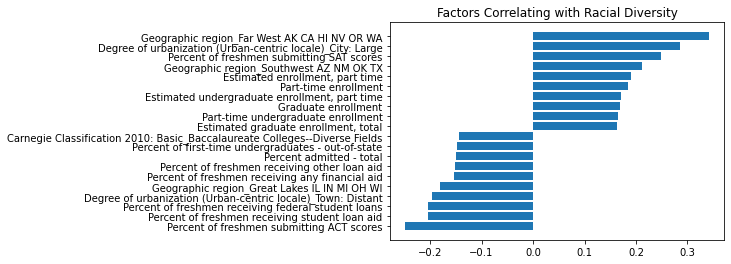

In [44]:
cmatrix = df.drop(columns = [c for c in df if c.startswith('Percent of total enrollment') 
                                           or c.startswith('Percent of undergraduate') 
                                           or c.startswith('Percent of graduate')
                  ] ).drop(columns = ['Name']).corr()

corr_to_diversity = cmatrix['diversity_rank'].sort_values(ascending=True).iloc[np.r_[0:10, -13:-3]]

factors = list(corr_to_diversity.keys())
stats = [corr_to_diversity[k] for k in factors]

plt.barh(factors, stats)
plt.title("Factors Correlating with Racial Diversity")
plt.show()

Questions 4: What factors correlated (positively and negatively) with graduation rates?

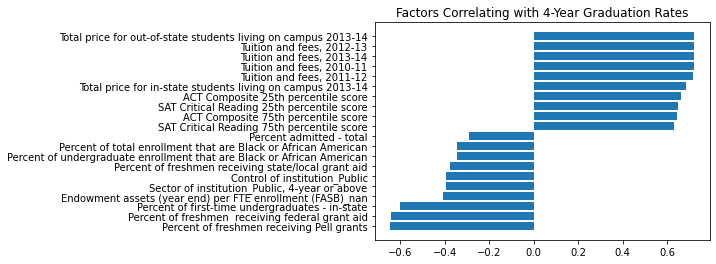

In [35]:
corr_to_graduation = df.corr()['Graduation rate - Bachelor degree within 4 years, total'].sort_values(ascending=True
                                                                                ).iloc[np.r_[0:10, -15:-5]]
factors = list(corr_to_graduation.keys())
stats = [corr_to_graduation[k] for k in factors]

plt.barh(factors, stats)
plt.title("Factors Correlating with 4-Year Graduation Rates")
plt.show()